In [1]:
! pip install nltk

In [2]:
!pip install -q wordcloud

In [3]:
!unzip "/content/archive (2).zip"

Archive:  /content/archive (2).zip
  inflating: spam.csv                


In [4]:
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv('/content/spam.csv')

In [32]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [34]:
df.duplicated().value_counts()

False    5157
True      415
Name: count, dtype: int64

In [35]:
df = df.drop_duplicates()

In [36]:
df.duplicated().value_counts()

False    5157
Name: count, dtype: int64

In [37]:
df['Category'].value_counts()

Category
ham     4516
spam     641
Name: count, dtype: int64

In [39]:

ham_categories = df[df["Category"] == "ham"]

random_indices = np.random.choice(ham_categories.index, 3875, replace=False)


df = df.drop(random_indices)

In [40]:
df['Category'].value_counts()

Category
ham     641
spam    641
Name: count, dtype: int64

In [43]:
df.rename(columns={"Category":"label","Message":"message"},inplace=True)

In [45]:
df['label'] = df['label'].replace({"ham": 0 ,"spam": 1})

In [47]:
df["length"] = df.message.str.len()
df.head()

,label,message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
5,1,FreeMsg Hey there darling it's been 3 week's n...,147
8,1,WINNER!! As a valued network customer you have...,157
9,1,Had your mobile 11 months or more? U R entitle...,154


In [48]:
df['message'] = df['message'].str.lower()
df.head()

,label,message,length
0,0,"go until jurong point, crazy.. available only ...",111
2,1,free entry in 2 a wkly comp to win fa cup fina...,155
5,1,freemsg hey there darling it's been 3 week's n...,147
8,1,winner!! as a valued network customer you have...,157
9,1,had your mobile 11 months or more? u r entitle...,154


In [50]:
# Replace email addresses with 'email'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')
# Replace URLs with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')
# Replace currency symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['message'] = df['message'].str.replace(r'£|$', 'dollers')
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['message'] = df['message'].str.replace(r'^?[\d]3?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
#replace numeric chars with 'numbr'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [51]:
#remove punctuations
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')
#replce whitespace btw terms with single space
df['message'] = df['message'].str.replace(r'\s+', ' ')
#remove leading and trailing whitesspace
df['message'] = df['message'].str.replace(r'^\s+|\s+?$', '')

In [53]:
df.sample(5)

,label,message,length
3991,1,(bank of granite issues strong-buy) explosive ...,137
3560,1,urgent! we are trying to contact u todays draw...,156
2983,0,"tonight? yeah, i'd be down for that",35
3231,0,i feel like a dick because i keep sleeping thr...,102
3743,0,hey i'm bored... so i'm thinking of u... so wa...,58


In [54]:
#remove stopwords
import string
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
df['message'] = df['message'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))


In [55]:
df['clean_length'] = df.message.str.len()
df.head()

,label,message,length,clean_length
0,0,"go jurong point, crazy.. available bugis n gre...",111,91
2,1,free entry wkly comp win fa cup final tkts 21s...,155,139
5,1,freemsg hey darling 3 week's word back! i'd li...,147,95
8,1,winner!! valued network customer selected rece...,157,132
9,1,mobile 11 months more? r entitled update lates...,154,114


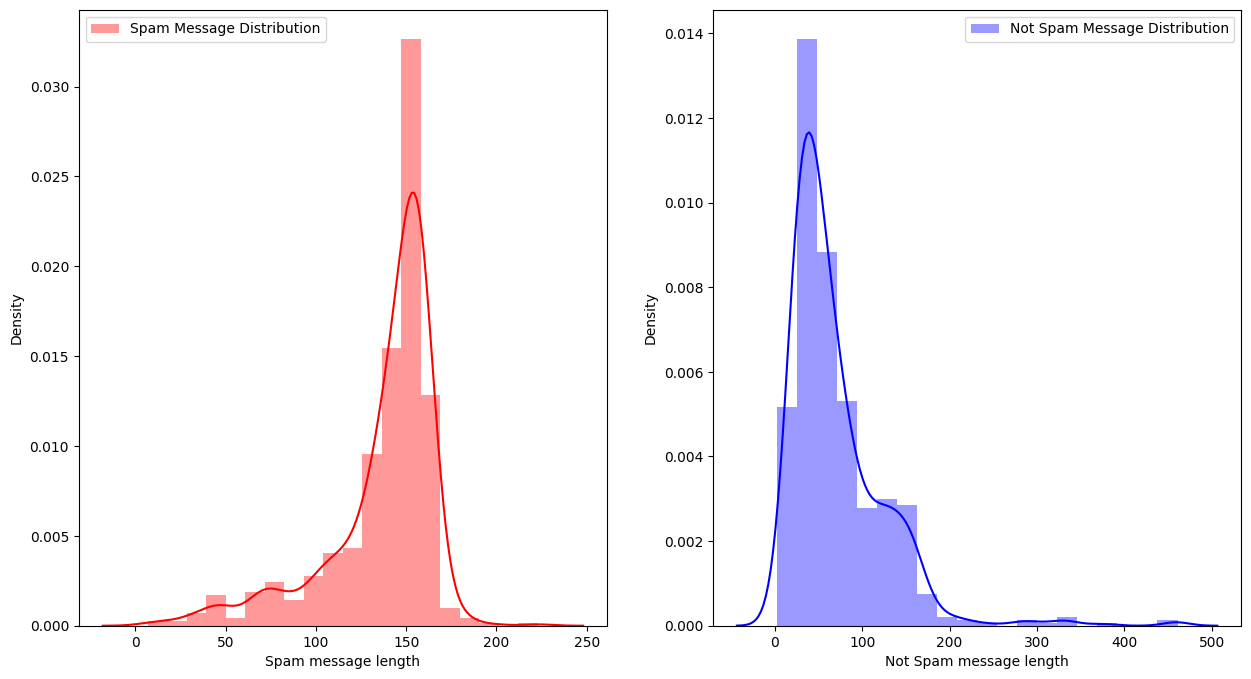

In [57]:

f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

plt.show()

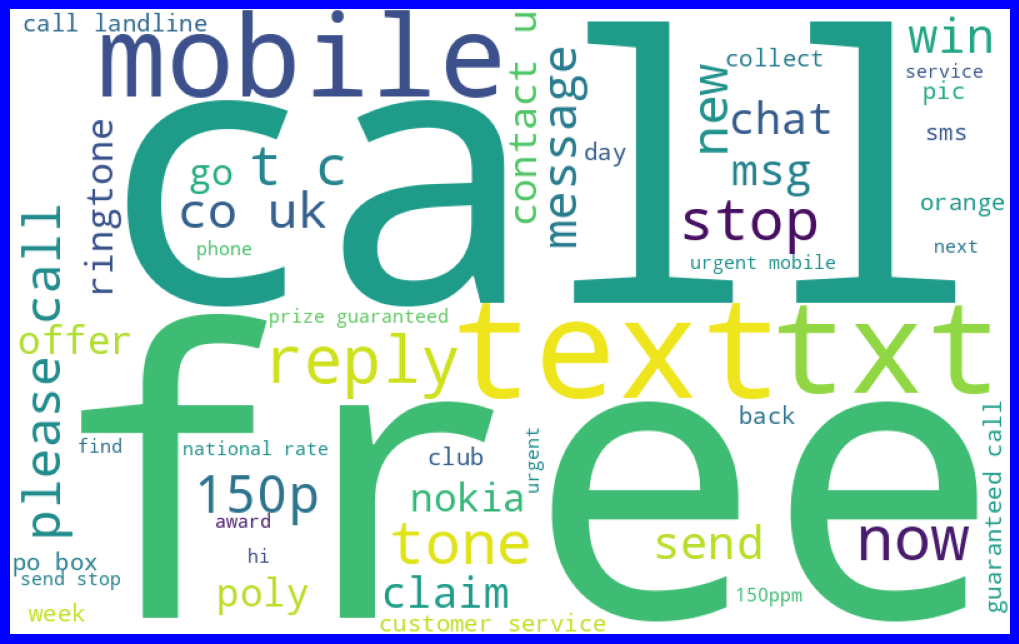

In [58]:
#Getting sense of loud words in spam
from wordcloud import WordCloud


spams = df['message'][df['label']==1]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

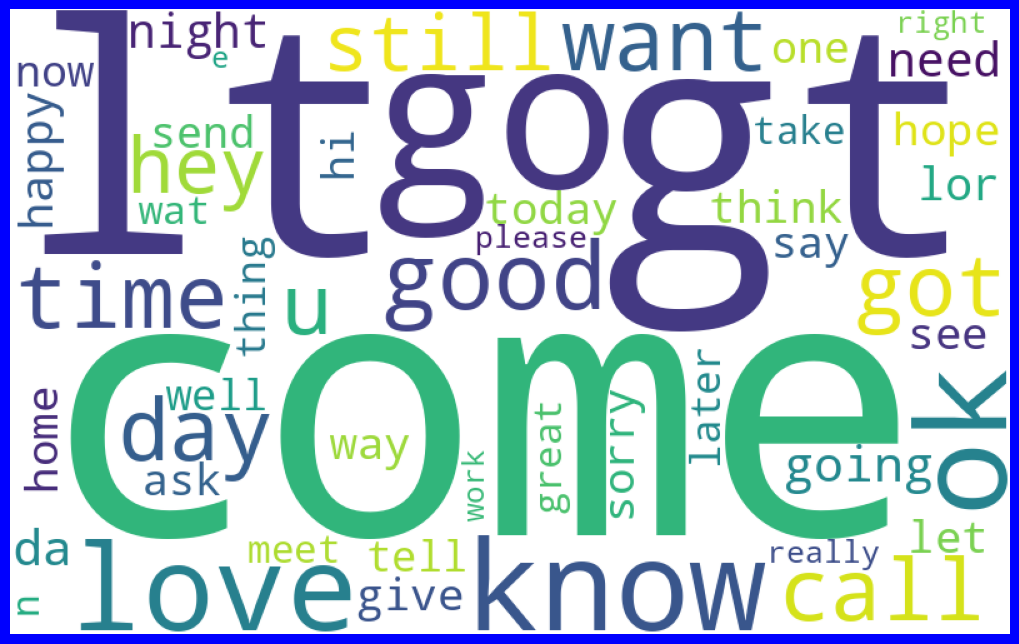

In [59]:
from wordcloud import WordCloud

not_spams = df['message'][df['label']==0]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [60]:
tf_vec = TfidfVectorizer()

svm = SVC( C = 1.0,kernel='linear',degree=3,gamma='auto')

features = tf_vec.fit_transform(df['message'])

x = features
y = df['label']

In [67]:
X_train,x_test,Y_train,y_test = train_test_split(x,y,random_state=42,test_size=0.2)

svm.fit(X_train,Y_train)

SVC(gamma='auto', kernel='linear')

In [68]:
y_pred = model.predict(x_test)

In [70]:
print('Aniqlik = > ',accuracy_score(y_test,y_pred))

Aniqlik = >  0.9260700389105059


In [71]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       134
           1       0.96      0.88      0.92       123

    accuracy                           0.93       257
   macro avg       0.93      0.92      0.93       257
weighted avg       0.93      0.93      0.93       257



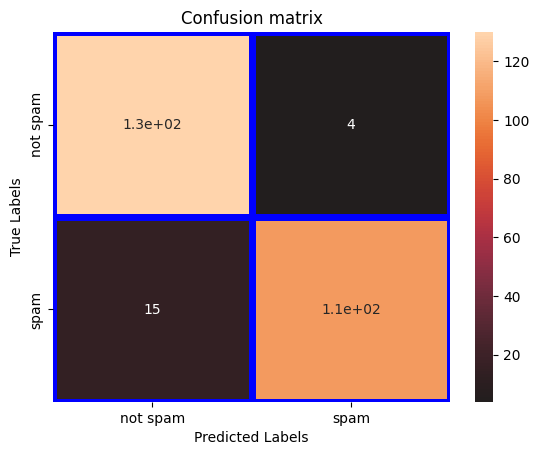

In [72]:
conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='b',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['not spam','spam'])
ax.yaxis.set_ticklabels(['not spam','spam'])
plt.show()


In [75]:


def preprocess_text(text):
    # Preprocess the input text (similar to what you did for training data)
    # You may need to apply the same preprocessing steps as you did before, such as removing stopwords
    # For simplicity, let's assume you've already defined the preprocessing steps in the `preprocess_text` function
    processed_text = text
    return processed_text

# Manually input text
input_text = input("Enter the text to classify: ")

# Preprocess the input text
processed_input_text = preprocess_text(input_text)

# Vectorize the processed input text
input_features = tf_vec.transform([processed_input_text])

# Predict the category
predicted_category = svm.predict(input_features)

# Print the predicted category
if predicted_category == 1:
    print("Predicted category: Spam")
else:
    print("Predicted category: Not Spam")


Enter the text to classify: Your free ringtone is waiting to be collected. Simply text the password \MIX\" to 85069 to verify.
Predicted category: Spam
